<center>
<h1>
<h1>APM 53674: ALTeGraD</h1>
<h2>Lab Session 1: Neural Machine Translation and Language Modeling</h2>
<h4>Lecture: Prof. Michalis Vazirgiannis<br>
Lab: Dr. Hadi Abdine and Yang Zhang</h4>
<h5>Monday, September 30, 2025</h5>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes theoretical introductions, <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit <a href='https://forms.gle/9dyaes6dimfvyjwq6' target="_blank">here</a> a <B>.ipynb</B> file named <b>Lastname_Firstname.ipynb</b> containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student. The deadline for this lab is <b>October 05
, 2025 11:59 PM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero).
</p>
<hr style="border:5px solid gray"> </hr>


## <b>Neural Machine Translation</b></h2>

<h3><b>1. Learning Objective:</b></h2>
<p style="text-align: justify;">
In this lab, you will learn about sequence to sequence (seq2seq) architectures.
More precisely, we will implement the Neural Machine Translation (NMT) model described in <a href='https://arxiv.org/abs/1508.04025'>[Luong et al., 2015]</a> using Python 3.6 and PyTorch (the latest version).
The only difference is that we will be using non-stacked RNNs, whereas <a href='https://arxiv.org/abs/1508.04025'>[Luong et al., 2015]</a> uses stacked RNNs.

We will train our model on the task of English to French translation, using a set of sentence pairs from <a href='http://www.manythings.org/anki/'>http://www.manythings.org/anki/</a>, originally extracted from the Tatoeba project: <a href='https://tatoeba.org/eng/'>https://tatoeba.org/eng/</a>.

Our dataset features 136,521 pairs for training and 34,130 pairs for testing, which is quite small, but enough for the purpose of this lab.
The average size of a source sentence is 7.6 while the average size of a target sentence is 8.3.

$\underline{\textbf{Note}}$: the pairs have already been preprocessed.
Each sentence was turned into a list of integers starting from 4.
The integers correspond to indexes in the source and target vocabularies, that have been constructed from the training set, and in which the most frequent words have index 4.
0, 1, 2 and 3 are reserved respectively for the padding, out-of-vocabulary, start of sentence, and end of sentence special tokens.

<h3><b>2. Recurrent Neural Networks:</b></h3>
<p style="text-align: justify;">

While CNNs are good at dealing with grids, RNNs were specifically developed to be used with sequences.
As shown in Fig. 1, a RNN can be viewed as a chain of simple neural layers that share the same parameters.
From a high level, a RNN is fed an ordered list of input vectors $\big\{x_{1},...,x_{T}\big\}$ as well as an initial hidden state $h_{0}$ initialized to all zeros, and returns an ordered list of hidden states $\big\{h_{1},...,h_{T}\big\}$, as well as an ordered list of output vectors $\big\{y_{1},...,y_{T}\big\}$.
The hidden states may serve as input to the RNN units above in the case of a stacked architecture, or directly be used as they are (e.g., by the attention mechanism).
The hidden states correspond more or less to the "short-term" memory of the network.
<center>
<table><tr>
<td> <img src='https://1drv.ms/i/c/ae69638675180117/UQQXARh1hmNpIICuu4QBAAAAAMrZ9Edq70cBsjo?width=498&height=246' alt="Drawing" width= '500px'/> </td>
<td> <img src="https://1drv.ms/i/c/ae69638675180117/UQQXARh1hmNpIICuvIQBAAAAAJVN-1WBTh55QtY?width=1336&height=733" alt="Drawing" width='500px'/> </td>
</tr></table>

<b>Figure 1:</b> Left: 3 steps of an unrolled RNN (adapted from <a href='http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/'>Denny Britz' blog</a>). Right: 3 steps of an unrolled stacked RNN.
The hidden states at a given position flow vertically through the RNN layers. On both sides, each circle represents a  RNN unit. </a><br>
</center>

<h3><b>3. Sequence-to-sequence architecture:</b></h3>
<p style="text-align: justify;">
Our input and output are sequences of words, respectively $x = \big(x_1, \dots ,x_{T_x}\big)$ and $y = \big(y_1, \dots ,y_{T_y}\big)$.
$x$ and $y$ are usually referred to as the $\textit{source}$ and $\textit{target}$ sentences.
<h4><b>3.1. Encoder</b></h4>
<p style="text-align: justify;">
Our encoder is a non-stacked unidirectional RNN with GRU units (see the appendix for details about the GRU.)



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from nltk import word_tokenize
import sys
import json
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: </b><br>
Fill the gaps in the $\texttt{forward}$ function of the $\texttt{Encoder}$ class.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [7]:
class Encoder(nn.Module):
    '''
    to be passed the entire source sequence at once
    we use padding_idx in nn.Embedding so that the padding vector does not take gradient (always zero)
    https://pytorch.org/docs/stable/nn.html#gru
    '''
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)

    def forward(self, input):
        word_vectors =self.embedding(input)
        hs,_ =  self.rnn(word_vectors)
        return hs

<h4><b>3.2. Decoder</b></h4>
<p style="text-align: justify;">
Our decoder is a non-stacked unidirectional RNN.
It is a neural language model conditioned not only on the previously generated target words but also on the source sentence.
More precisely, it generates the target sentence $y=(y_1,\dots,y_{T_y})$ one word $y_t$ at a time based on the distribution:

\begin{equation}
P\big[y_t|\{y_{1},...,y_{t-1}\},c_t\big] = \mathrm{softmax}\big(W_s\tilde{h}_t\big)
\end{equation}

where $\tilde{h}_t$, the \textit{attentional} hidden state, is computed as (biases are not shown for simplicity):

\begin{equation}
\tilde{h}_t = \mathrm{tanh}\big(W_c\big[c_t;h_t\big]\big)
\end{equation}

 $h_t$ is the $t^{th}$ hidden state of the decoder, $c_t$ is the source context vector, and $\big[;\big]$ denotes concatenation. $W_s$ and $W_c$ are matrices of trainable parameters.

$\textbf{Note:}$ while all the inputs of the encoder (i.e., all the words of the input sentence) are known at encoding time, the decoder generates one target word at a time, and uses as input at time $t$ its prediction from time $t-1$.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: </b><br>
Fill the gaps in the $\texttt{forward}$ function of the $\texttt{Decoder}$ class.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [8]:
class Decoder(nn.Module):
    '''to be used one timestep at a time
       see https://pytorch.org/docs/stable/nn.html#gru'''
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
        self.ff_concat = nn.Linear(2*hidden_dim,hidden_dim)
        self.predict = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, source_context, h):
        # fill the gap # (1,batch) -> (1,batch,feat)
        word_vector = self.embedding (input)

        # fill the gap # (1,batch,feat)
        h,_= self.rnn(word_vector,h)

        # fill the gap # (1,batch,2*feat) -> (1,batch,feat)
        tilde_h = torch.tanh(self.ff_concat(torch.cat((source_context, h), dim=2)))

        # (1,batch,feat) -> (1,batch,vocab)
        prediction = self.predict(tilde_h)

        return prediction, h

<h4><b>3.3. Global attention mechanism</b></h4>
<p style="text-align: justify;">
The context vector $c_t$ is computed as a weighted sum of the encoder's hidden states $\bar{h}_i$.
The vector of weights $\alpha_{t}$ is obtained by applying a softmax to the output of an $\textit{alignment}$ operation ($\texttt{score()}$) between the current target hidden state $h_t$ and all source hidden states $\bar{h}_{i}$'s.
$\alpha_{t}$ indicates which words in the source sentence are the most likely to help in predicting the next word.
$\texttt{score()}$ can in theory be any comparison function.
In our implementation, we will use the $\texttt{concat}$ attention formulation of <a href='https://arxiv.org/abs/1508.04025'>[Luong et al., 2015]</a> (see section 3.1 of the paper).
An overview is provided in Fig. 2.  at a time, and uses as input at time $t$ its prediction from time $t-1$.
<center>
<img width='800px' src='https://1drv.ms/i/c/ae69638675180117/UQQXARh1hmNpIICutoQBAAAAAMg4GcKQUg3VOR8?width=1836&height=874' />
<br>
<b>Figure 2:</b>Summary of the $\textit{global attention}$ mechanism <a href='https://arxiv.org/abs/1508.04025'>[Luong et al., 2015]</a> <br>
</center>


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
Fill the gaps in the $\texttt{forward}$ function of the $\texttt{seq2seqAtt}$ class.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [9]:
class seq2seqAtt(nn.Module):
    '''
    concat global attention a la Luong et al. 2015 (subsection 3.1)
    https://arxiv.org/pdf/1508.04025.pdf
    '''
    def __init__(self, hidden_dim, hidden_dim_s, hidden_dim_t):
        super(seq2seqAtt, self).__init__()
        self.ff_concat = nn.Linear(hidden_dim_s+hidden_dim_t,hidden_dim)
        self.ff_score = nn.Linear(hidden_dim,1,bias=False) # just a dot product here

    def forward(self,target_h,source_hs):
      # (1,batch,feat) -> (seq,batch,feat)
        target_h_rep = target_h.repeat(source_hs.size(0),1,1)

        # fill the gap # source_hs is (seq,batch,feat)
        concat_output = self.ff_concat(torch.cat((target_h_rep, source_hs), dim=2))

        # (seq,batch,feat) -> (seq,batch,1)
        scores = self.ff_score(torch.tanh(concat_output))

        # (seq,batch,1) -> (seq,batch). dim=2 because we don't want to squeeze the batch dim if batch size = 1
        scores = scores.squeeze(dim=2)

        # attention weights
        norm_scores = torch.softmax(scores, 0)

         # (seq,batch,feat) -> (feat,seq,batch)
        source_hs_p = source_hs.permute((2,0,1))

        # (seq,batch) * (feat,seq,batch) (* checks from right to left that the dimensions match)
        weighted_source_hs = (norm_scores * source_hs_p)

        # (feat,seq,batch) -> (seq,batch,feat) -> (1,batch,feat); keepdim otherwise sum squeezes
        ct = torch.sum(weighted_source_hs.permute((1,2,0)),0,keepdim=True)
        return ct, norm_scores.squeeze(1)

<h3><b>4. Training and Evaluation:</b></h3>
<p style="text-align: justify;">

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Fill the gaps in the $\texttt{forward}$ function of the $\texttt{seq2seqModel}$ class.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [10]:
class seq2seqModel(nn.Module):
    '''the full seq2seq model'''
    ARGS = ['vocab_s','source_language','vocab_t_inv','embedding_dim_s','embedding_dim_t',
     'hidden_dim_s','hidden_dim_t','hidden_dim_att','do_att','padding_token',
     'oov_token','sos_token','eos_token','max_size']
    def __init__(self, vocab_s, source_language, vocab_t_inv, embedding_dim_s, embedding_dim_t,
                 hidden_dim_s, hidden_dim_t, hidden_dim_att, do_att, padding_token,
                 oov_token, sos_token, eos_token, max_size):
        super(seq2seqModel, self).__init__()
        self.vocab_s = vocab_s
        self.source_language = source_language
        self.vocab_t_inv = vocab_t_inv
        self.embedding_dim_s = embedding_dim_s
        self.embedding_dim_t = embedding_dim_t
        self.hidden_dim_s = hidden_dim_s
        self.hidden_dim_t = hidden_dim_t
        self.hidden_dim_att = hidden_dim_att
        self.do_att = do_att # should attention be used?
        self.padding_token = padding_token
        self.oov_token = oov_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.max_size = max_size

        self.max_source_idx = max(list(vocab_s.values()))
        print('max source index',self.max_source_idx)
        print('source vocab size',len(vocab_s))

        self.max_target_idx = max([int(elt) for elt in list(vocab_t_inv.keys())])
        print('max target index',self.max_target_idx)
        print('target vocab size',len(vocab_t_inv))

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.encoder = Encoder(self.max_source_idx+1,self.embedding_dim_s,self.hidden_dim_s,self.padding_token).to(self.device)
        self.decoder = Decoder(self.max_target_idx+1,self.embedding_dim_t,self.hidden_dim_t,self.padding_token).to(self.device)

        if self.do_att:
            self.att_mech = seq2seqAtt(self.hidden_dim_att,self.hidden_dim_s,self.hidden_dim_t).to(self.device)

    def my_pad(self,my_list):
        '''my_list is a list of tuples of the form [(tensor_s_1,tensor_t_1),...,(tensor_s_batch,tensor_t_batch)]
        the <eos> token is appended to each sequence before padding
        https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_sequence'''
        batch_source = pad_sequence([torch.cat((elt[0],torch.LongTensor([self.eos_token]))) for elt in my_list],batch_first=True,padding_value=self.padding_token)
        batch_target = pad_sequence([torch.cat((elt[1],torch.LongTensor([self.eos_token]))) for elt in my_list],batch_first=True,padding_value=self.padding_token)
        return batch_source,batch_target

    def forward(self,input,max_size,is_prod):

        if is_prod:
            input = input.unsqueeze(1) # (seq) -> (seq,1) 1D input <=> we receive just one sentence as input (predict/production mode)

        current_batch_size = input.size(1)

        # fill the gap #
        # use the encoder

        # (seq,batch)/(seq,1) -> (seq,batch,feat)/(seq,1,feat)
        source_hs =self.encoder.forward(input)

        # = = = decoder part (one timestep at a time)  = = =

        # init (1,batch,feat)
        target_h = torch.zeros(size=(1,current_batch_size,self.hidden_dim_t)).to(self.device)

        # fill the gap #
        # (initialize target_input with the proper token)

        # init (1,batch)
        target_input = torch.LongTensor([self.sos_token]).repeat(current_batch_size).unsqueeze(0).to(self.device)

        pos = 0
        eos_counter = 0
        logits = []
        weights = []

        while True:

            if self.do_att:
                source_context = self.att_mech(target_h,source_hs) # (1,batch,feat)
                weights.append(source_context[1].tolist()) # attention weights
                source_context = source_context[0]
            else:
                source_context = source_hs[-1,:,:].unsqueeze(0) # (1,batch,feat) last hidden state of encoder

            # fill the gap #
            # use the decoder
            prediction, target_h = self.decoder.forward(target_input,source_context,target_h)

            # (1,batch,vocab)
            logits.append(prediction)

            # fill the gap #
            # get the next input to pass the decoder
            target_input = prediction.argmax(dim=2)

            eos_counter += torch.sum(target_input==self.eos_token).item()

            pos += 1
            if pos>=max_size or (eos_counter == current_batch_size and is_prod):
                break

        to_return = torch.cat(logits,0) # logits is a list of tensors -> (seq,batch,vocab)

        if is_prod:
            to_return = to_return.squeeze(dim=1) # (seq,vocab)

        return to_return, weights

    def fit(self, trainingDataset, testDataset, lr, batch_size, n_epochs, patience):

        parameters = [p for p in self.parameters() if p.requires_grad]

        optimizer = optim.Adam(parameters, lr=lr)

        criterion = torch.nn.CrossEntropyLoss(ignore_index=self.padding_token) # the softmax is inside the loss!

        # https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
        # we pass a collate function to perform padding on the fly, within each batch
        # this is better than truncation/padding at the dataset level
        train_loader = data.DataLoader(trainingDataset, batch_size=batch_size,
                                       shuffle=True, collate_fn=self.my_pad) # returns (batch,seq)

        test_loader = data.DataLoader(testDataset, batch_size=512,
                                      collate_fn=self.my_pad)

        tdqm_dict_keys = ['loss', 'test loss']
        tdqm_dict = dict(zip(tdqm_dict_keys,[0.0,0.0]))

        patience_counter = 1
        patience_loss = 99999

        for epoch in range(n_epochs):

            with tqdm(total=len(train_loader),unit_scale=True,postfix={'loss':0.0,'test loss':0.0},
                      desc="Epoch : %i/%i" % (epoch, n_epochs-1),ncols=100) as pbar:
                for loader_idx, loader in enumerate([train_loader, test_loader]):
                    total_loss = 0
                    # set model mode (https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
                    if loader_idx == 0:
                        self.train()
                    else:
                        self.eval()
                    for i, (batch_source,batch_target) in enumerate(loader):
                        batch_source = batch_source.transpose(1,0).to(self.device) # RNN needs (seq,batch,feat) but loader returns (batch,seq)
                        batch_target = batch_target.transpose(1,0).to(self.device) # (seq,batch)

                        # are we using the model in production / as an API?
                        is_prod = len(batch_source.shape)==1 # if False, 2D input (seq,batch), i.e., train or test

                        if is_prod:
                            max_size = self.max_size
                            self.eval()
                        else:
                            max_size = batch_target.size(0) # no need to continue generating after we've exceeded the length of the longest ground truth sequence

                        unnormalized_logits = self.forward(batch_source,max_size,is_prod)[0]

                        sentence_loss = criterion(unnormalized_logits.flatten(end_dim=1),batch_target.flatten())

                        total_loss += sentence_loss.item()

                        tdqm_dict[tdqm_dict_keys[loader_idx]] = total_loss/(i+1)

                        pbar.set_postfix(tdqm_dict)

                        if loader_idx == 0:
                            optimizer.zero_grad() # flush gradient attributes
                            sentence_loss.backward() # compute gradients
                            optimizer.step() # update
                            pbar.update(1)

            if total_loss > patience_loss:
                patience_counter += 1
            else:
                patience_loss = total_loss
                patience_counter = 1 # reset

            if patience_counter>patience:
                break

    def sourceNl_to_ints(self,source_nl):
        '''converts natural language source sentence into source integers'''
        source_nl_clean = source_nl.lower().replace("'",' ').replace('-',' ')
        source_nl_clean_tok = word_tokenize(source_nl_clean,self.source_language)
        source_ints = [int(self.vocab_s[elt]) if elt in self.vocab_s else \
                       self.oov_token for elt in source_nl_clean_tok]

        source_ints = torch.LongTensor(source_ints).to(self.device)
        return source_ints

    def targetInts_to_nl(self,target_ints):
        '''converts integer target sentence into target natural language'''
        return ['<PAD>' if elt==self.padding_token else '<OOV>' if elt==self.oov_token \
                else '<EOS>' if elt==self.eos_token else '<SOS>' if elt==self.sos_token\
                else self.vocab_t_inv[elt] for elt in target_ints]

    def predict(self,source_nl):
        source_ints = self.sourceNl_to_ints(source_nl)
        logits = self.forward(source_ints,self.max_size,True) # (seq) -> (<=max_size,vocab)
        target_ints = logits[0].argmax(-1).squeeze() # (<=max_size,1) -> (<=max_size)
        target_nl = self.targetInts_to_nl(target_ints.tolist())
        return ' '.join(target_nl), logits[1]

    def save(self,path_to_file):
        attrs = {attr:getattr(self,attr) for attr in self.ARGS}
        attrs['state_dict'] = self.state_dict()
        torch.save(attrs,path_to_file)

    @classmethod # a class method does not see the inside of the class (a static method does not take self as first argument)
    def load(cls,path_to_file):
        attrs = torch.load(path_to_file, map_location=lambda storage, loc: storage) # allows loading on CPU a model trained on GPU, see https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349/6
        state_dict = attrs.pop('state_dict')
        new = cls(**attrs) # * list and ** names (dict) see args and kwargs
        new.load_state_dict(state_dict)
        return new

### Download the data and the pretrained model:

In [11]:
import urllib

urllib.request.urlretrieve("https://nuage.lix.polytechnique.fr/public.php/dav/files/FLttXTmeFSDNx7H", "data.zip")
urllib.request.urlretrieve("https://nuage.lix.polytechnique.fr/public.php/dav/files/6btZHdtYnyAAH3x", "pretrained_moodle.pt")
!unzip data.zip

path_to_data = './data/'
path_to_save_models = './'

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/pairs_train_ints.txt  
  inflating: __MACOSX/data/._pairs_train_ints.txt  
  inflating: data/pairs_test_ints.txt  
  inflating: __MACOSX/data/._pairs_test_ints.txt  
  inflating: data/README.txt         
  inflating: __MACOSX/data/._README.txt  
  inflating: data/vocab_target.json  
  inflating: __MACOSX/data/._vocab_target.json  
  inflating: data/vocab_source.json  
  inflating: __MACOSX/data/._vocab_source.json  


### Define the dataloader:

In [12]:
class Dataset(data.Dataset):
  def __init__(self, pairs):
        self.pairs = pairs

  def __len__(self):
        return len(self.pairs) # total nb of observations

  def __getitem__(self, idx):
        source, target = self.pairs[idx] # one observation
        return torch.LongTensor(source), torch.LongTensor(target)

def load_pairs(train_or_test):
    with open(path_to_data + 'pairs_' + train_or_test + '_ints.txt', 'r', encoding='utf-8') as file:
        pairs_tmp = file.read().splitlines()
    pairs_tmp = [elt.split('\t') for elt in pairs_tmp]
    pairs_tmp = [[[int(eltt) for eltt in elt[0].split()],[int(eltt) for eltt in \
                  elt[1].split()]] for elt in pairs_tmp]
    return pairs_tmp

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Check that your implementation is correct by running $\texttt{the following cell}$ for a few epochs and verifying that the loss decreases.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [13]:
do_att = True # should always be set to True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_train = load_pairs('train')
pairs_test = load_pairs('test')

with open(path_to_data + 'vocab_source.json','r') as file:
    vocab_source = json.load(file) # word -> index

with open(path_to_data + 'vocab_target.json','r') as file:
    vocab_target = json.load(file) # word -> index

vocab_target_inv = {v:k for k,v in vocab_target.items()} # index -> word
print('data loaded')
training_set = Dataset(pairs_train)
test_set = Dataset(pairs_test)
print('data prepared')
print('= = = attention-based model?:',str(do_att),'= = =')

model = seq2seqModel(vocab_s=vocab_source,
                      source_language='english',
                      vocab_t_inv=vocab_target_inv,
                      embedding_dim_s=40,
                      embedding_dim_t=40,
                      hidden_dim_s=30,
                      hidden_dim_t=30,
                      hidden_dim_att=20,
                      do_att=do_att,
                      padding_token=0,
                      oov_token=1,
                      sos_token=2,
                      eos_token=3,
                      max_size=30).to(device) # max size of generated sentence in prediction mode

model.fit(training_set,test_set,lr=0.001,batch_size=64,n_epochs=20,patience=2)
model.save(path_to_save_models + 'my_model.pt')


data loaded
data prepared
= = = attention-based model?: True = = =
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456


Epoch : 0/19: 100%|██████████████████| 2.13k/2.13k [01:52<00:00, 18.9it/s, loss=5.16, test loss=4.6]
Epoch : 1/19: 100%|█████████████████| 2.13k/2.13k [01:56<00:00, 18.3it/s, loss=4.35, test loss=4.08]
Epoch : 2/19: 100%|█████████████████| 2.13k/2.13k [01:54<00:00, 18.6it/s, loss=3.92, test loss=3.77]
Epoch : 3/19: 100%|█████████████████| 2.13k/2.13k [01:54<00:00, 18.6it/s, loss=3.65, test loss=3.56]
Epoch : 4/19: 100%|█████████████████| 2.13k/2.13k [01:53<00:00, 18.8it/s, loss=3.46, test loss=3.41]
Epoch : 5/19: 100%|██████████████████| 2.13k/2.13k [01:54<00:00, 18.7it/s, loss=3.32, test loss=3.3]
Epoch : 6/19: 100%|██████████████████| 2.13k/2.13k [01:57<00:00, 18.2it/s, loss=3.2, test loss=3.21]
Epoch : 7/19: 100%|█████████████████| 2.13k/2.13k [01:58<00:00, 18.0it/s, loss=3.11, test loss=3.13]
Epoch : 8/19: 100%|█████████████████| 2.13k/2.13k [01:57<00:00, 18.2it/s, loss=3.03, test loss=3.07]
Epoch : 9/19: 100%|█████████████████| 2.13k/2.13k [02:01<00:00, 17.6it/s, loss=2.96, test l

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: </b><br>
Run the following cell using the pre-trained weights.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [14]:
model = seq2seqModel.load(path_to_save_models + 'pretrained_moodle.pt')
to_test = ['I am a student.',
            'I have a red car.',  # inversion captured
            'I love playing video games.',
            'This river is full of fish.', # plein vs pleine (accord)
            'The fridge is full of food.',
            'The cat fell asleep on the mat.',
            'my brother likes pizza.', # pizza is translated to 'la pizza'
            'I did not mean to hurt you', # translation of mean in context
            'She is so mean',
            'Help me pick out a tie to go with this suit!', # right translation
            "I can't help but smoking weed", # this one and below: hallucination
            'The kids were playing hide and seek',
            'The cat fell asleep in front of the fireplace']

for elt in to_test:
    print('= = = = = \n','%s -> %s' % (elt, model.predict(elt)[0]))

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
= = = = = 
 I am a student. -> je suis étudiant . . . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I have a red car. -> j ai une voiture rouge . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I love playing video games. -> j adore jouer à jeux jeux jeux vidéo . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 This river is full of fish. -> cette rivière est pleine de poisson . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The fridge is full of food. -> le frigo est plein de nourriture . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The cat fell asleep on the mat. -> le chat s est endormi sur le tapis . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 my brother likes pizza. -> mon frère aime la pizza . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I did not mean to hurt you -> je n ai pas voulu intention de blesser blesser

In [17]:
to_test = ['My dog is lazy.',
            'I love cats.',  # inversion captured
            'I love playing with you.',
            'This river is full of fish.', # plein vs pleine (accord)
            'The fridge is full of food.',
            'The cat fell asleep on the mat.',
            'my brother likes pizza.', # pizza is translated to 'la pizza'
            'I did not mean to hurt you', # translation of mean in context
            'She is nasty',
            'Help me pick out a tie to go with this suit!', # right translation
            "I can't help but smoking weed", # this one and below: hallucination
            'The kids were playing hide and seek',
            'The cat fell asleep in front of the fireplace']

for elt in to_test:
    print('= = = = = \n','%s -> %s' % (elt, model.predict(elt)[0]))

= = = = = 
 My dog is lazy. -> mon chien est paresseux . . . . paresseux . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I love cats. -> j adore les chats . . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I love playing with you. -> j adore jouer avec toi . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 This river is full of fish. -> cette rivière est pleine de poisson . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The fridge is full of food. -> le frigo est plein de nourriture . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The cat fell asleep on the mat. -> le chat s est endormi sur le tapis . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 my brother likes pizza. -> mon frère aime la pizza . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I did not mean to hurt you -> je n ai pas voulu intention de blesser blesser blesser blesser blesser blesser . blesser . blesser . . . . . . . . . . . . .
= = = = = 
 She i

<h3><b>5. Questions:</b></h3>

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 1 (5 points): </b><br>
What do you think about our greedy decoding strategy? Base your answer on slides 87-95 from this <a href='https://nlp.stanford.edu/projects/nmt/Luong-Cho-Manning-NMT-ACL2016-v4.pdf'>presentation</a> (taken from this <a href='https://sites.google.com/site/acl16nmt/home'>ACL tutorial</a>).
<hr style="border:10px solid red"> </hr>
</font></h4>








<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 1: </b><br>

It seems that the greedy decoding approach does not yield the best translation accuracy. At each time step \( t \), it selects the word with the highest immediate probability:

$$
x_t = \arg \max \log p(x_t | x_{<t}, y)
$$

However, in order to have a good performance, the main goal is to maximise the total log probability:

$$
\log p((x_t)_t | y) = \Sigma_{t=1}^n \log p(x_t | x_{<t}, y)
$$

Thus, optimizing the local probability at each step may not lead to the highest overall probability.
Choosing the most likely word at a specific step can reduce the probabilities of the next words, whereas selecting a less likely option might result in a higher total score across all steps.

This situation is similar to finding the shortest path in a graph: a purely greedy approach (always picking the closest next node) might lead to a suboptimal global path.

For this reason, the beam search method tends to improve accuracy by maintaining multiple candidate sequences in parallel. Nevertheless, the greedy method remains much faster and more efficient in terms of memory and computation.


<hr style="border:10px solid red"> </hr>
</font></h4>



<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 2 (5 points): </b><br>
What major problem do you observe with our translations?
How could we remediate this issue? You may find inspiration from reading <a href='https://arxiv.org/abs/1508.04025'>[Luong et al., 2015]</a> and <a href='https://arxiv.org/abs/1601.04811'>[Tu et al., 2016]</a>.
<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 2: </b><br>

Apparently the results are not pretty good with long sentences. One way of remediate this, as it was mentioned in the experiments sections of the papers, is to use NMT coverage could fix it by checking the undertranslations.

<hr style="border:10px solid red"> </hr>
</font></h4>



<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 3 (5 points): </b><br>
Write some code to visualize source/target alignments in the style of Fig. 3 in <a href='https://arxiv.org/abs/1409.0473'>[Bahdanau et al., 2014]</a> or Fig. 7 in <a href='https://arxiv.org/abs/1508.04025'>[Luong et al., 2015]</a>.
Interpret your figures for some relevant examples (e.g. to illustrate adjective-noun inversion)
<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 3: </b><br>

<hr style="border:10px solid red"> </hr>
</font></h4>

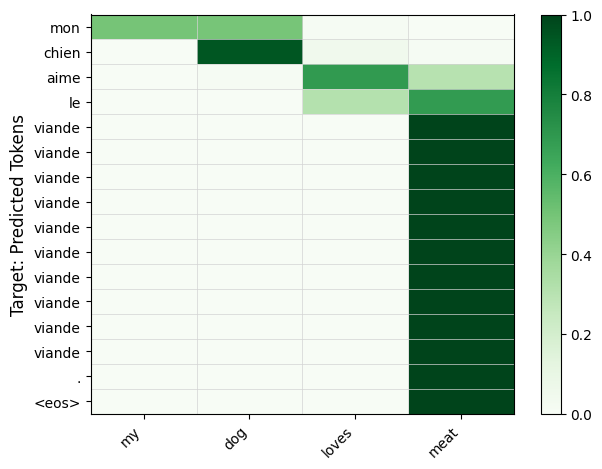

(['my', 'dog', 'loves', 'meat'],
 ['mon',
  'chien',
  'aime',
  'le',
  'viande',
  'viande',
  'viande',
  'viande',
  'viande',
  'viande',
  'viande',
  'viande',
  'viande',
  'viande',
  '.',
  '<eos>'])

In [25]:
def tokenize(text):
    # Lowercase and normalize punctuation
    cleaned = (
        text.lower()
        .replace("'", " ")
        .replace("-", " ")
        .replace(".", " . ")
    )
    return cleaned.split()


def visualize_attention(model, src_sentence):

    pred_sentence, attn_weights = model.predict(src_sentence)

    src_tokens = tokenize(src_sentence)
    tgt_tokens = tokenize(pred_sentence)
    attn_matrix = np.array(attn_weights)

    fig, ax = plt.subplots()


    heatmap = ax.imshow(
        attn_matrix,
        interpolation="nearest",
        aspect="auto",
        cmap="Greens"
    )

    fig.colorbar(heatmap, ax=ax)


    ax.set_xticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45, ha="right")

    ax.set_yticks(range(len(tgt_tokens)))
    ax.set_yticklabels(tgt_tokens)

    ax.set_ylabel("Target: Predicted Tokens", fontsize=12)


    ax.set_xticks(np.arange(attn_matrix.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(attn_matrix.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="lightgrey", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()
    plt.show()

    return src_tokens, tgt_tokens



visualize_attention(model, "My dog loves meat")





<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 4 (5 points): </b><br>
What do you observe in the translations of the sentences below?
What properties of language models does that illustrate?
Read <a href='https://arxiv.org/abs/1802.05365'>[Peters et al., 2018]</a> and <a href='https://arxiv.org/abs/1810.04805'>[Devlin et al., 2018]</a>  to get some ideas.
<ul>
<b><h4><font color='red'>
<li>$\texttt{I did not mean to hurt you}$
<li>$\texttt{She is so mean}$
</ul>
<hr style="border:10px solid red"> </hr>
</font></h4>



<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 4: </b><br>

The model produced the following translations: <br> - I did not mean to hurt you → je n ai pas voulu intention de blesser blesser blesser blesser blesser blesser . blesser . blesser . . . . . . . . . . . . . <br> - She is so mean → elle est tellement méchant méchant . <EOS> <br><br>

The word “mean” appears in both sentences but with two distinct senses.
Interestingly, the model is able to capture these differences — translating it once as “méchant” and another time as “vouloir intention de”.
This ability to interpret a word differently depending on its context is known as "Word Sense Disambiguation", which is addressed in <a href='https://arxiv.org/abs/1802.05365'>[Peters et al., 2018]</a>.
Because of the notion of nearest neighbors, the language model can infer the intended sense of the word from its surrounding context.

<hr style="border:10px solid red"> </hr>
</font></h4>


### <b>6. Appendix:</b>
<h4><b>6.1. GRU unit:</b></h4>
<p style="text-align: justify;">
As shown in Fig. 3, the GRU unit <a href='https://arxiv.org/abs/1406.1078'>[Cho et al., 2014]</a> is a simple RNN unit with two gates (reset and update):

\begin{equation}
\text{reset gate:}~~r_{t} = \sigma \big(U_{r}x_{t} + W_{r}h_{t-1} + b_r\big)
\end{equation}

\begin{equation}
\text{update gate:}~~z_{t} = \sigma \big(U_{z}x_{t} + W_{z}h_{t-1} + b_z\big)
\end{equation}

The candidate hidden state is computed as:

\begin{equation}
\hat{h}_{t} = \mathrm{tanh} \big(U_{h}x_{t} + W_{h} (r_t \circ h_{t-1}) + b_h\big)
\end{equation}

<center>
<img width='500px' src='https://1drv.ms/i/c/ae69638675180117/UQQXARh1hmNpIICuuYQBAAAAAEpvFJzwgjB2a3Y?width=703&height=489' />
<br>
<b>Figure 3:</b> GRU unit. Taken from <a href='http://colah.github.io/posts/2015-08-Understanding-LSTMs/'>Chris Olah's blog</a>.<br>
</center>

The reset gate determines how much of the information from the previous time steps (stored in $h_{t-1}$) should be discarded.
The new hidden state is finally obtained by linearly interpolating between the previous hidden state and the candidate one:

\begin{equation}
h_{t} = (1-z_t) \circ {h}_{t-1} + z_t \circ \hat{h}_{t}
\end{equation}